In [1]:
#! python
#from pyFWI import *
from FWIFunctions import *
import sys, re, datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import xarray as xr

## The requirements of the FWI calculation stipulate that 
### 2 m temperature (∘C), 10 m wind speed (km h−1), and 2 m relative humidity (%) measurements be taken at noon LST for each global time zone and that precipitation (mm) be accumulated over the previous 24 h ending at noon LST of each day 

#### Loadthe FWI data calculated by ECMWF. 
Data is downloaded from XXXX

In [12]:
import xarray as xr
# Load the NetCDF file
file_path = "~/Downloads/fire_weather_index_2018.nc"  # Replace with your NetCDF file path
ds = xr.open_dataset(file_path)

# View the dataset
print(ds)

## convert longitude from 0-360 to -180-180. 
fwi = ds.FWI
fwi['Longitude'] = fwi['Longitude'].where(fwi['Longitude'] < 180, fwi['Longitude']-360)
## reorder the data array based on longitude
fwi_sorted = fwi.sortby('Longitude')

<xarray.Dataset>
Dimensions:    (Longitude: 1440, Latitude: 721, Time: 365)
Coordinates:
  * Longitude  (Longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * Latitude   (Latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * Time       (Time) float64 1.0 2.0 3.0 4.0 5.0 ... 362.0 363.0 364.0 365.0
Data variables:
    crs        int32 ...
    FWI        (Time, Latitude, Longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.0-7)
    date:         2019-10-16 00:07:54


#### Overlay the state map

<AxesSubplot:>

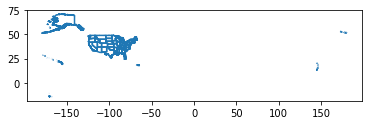

In [115]:
states = gpd.read_file('../cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
#states.boundary.plot()

fig, ax = plt.subplots(figsize=(12, 8))
contours=ax.contourf(fwi_sorted.Longitude, fwi_sorted.Latitude, fwi_sorted[210:240,:,:].mean('Time'),
                     levels=np.linspace(0,100,11),
                    cmap='hot_r')
#plt.colorbar(contours,extend='both')
states.boundary.plot(ax=ax)
ax.set_xlim([-126,-116])
ax.set_ylim([45,50])

### Load ERA5 data needed for FWI
- Note that precip of ERA5 is in a strange setup. It is in the format of (time, step) where time is the forecast/reference time and step is hours starting from the reference time. For example, if I want to download preciptation of UTC 0 to UTC 24 of Aug 1, what ERA5 provided is actually data in a format of (time, step), Where time is a length=3 forecast reference time -- UTC 18 of July 31, UTC 6 of Aug 1 and UTC 18 of Aug 1. Step is the hour into forecast. It doesn't have data for the first 5 steps and the last seven steps. 
- The preciptation variable needed is the 24-hour accumulated precipitation until local noon, which is UTC 20:00 for Washington. In order to get the previous 24-hour accumulated precipitation until local noon (UTC = 20:00 for Washington state) , I would need the 12-step at time==UTC 18 and then the 12-step at time==UTC6. 
- To get this variable, what I did is collapsing the time and step dimensions into one dimension. Then I average the 21 UTC of previous day to 20UTC of current day and make it the precipitation value of the current day. For example, to get FWI of Aug 1, I need T, q, and uv of Aug 1, and precip accumualted from 21UTC of July 31 to 20UTC of Aug 1. 
- relative humidity at 2m is not available for downloading. It can be calculated using T2m and Tdew at 2m. 


#### Calculate 24-hour accumulated precipitation

In [189]:
path = '/Users/xjliu/Desktop/My_research/Climate_Risk/climate-risk-map-hazards/FireWeatherIndex/'
ds_prec = xr.open_dataset(path+'precip.grib', engine='cfgrib') ## prec is 
#plt.contourf(var2.longitude,var2.latitude,var2.tp[0,5,:,:])
ds_prec_stacked = ds_prec.stack(timestep = ("time","step"))
ds_prec_stacked = ds_prec_stacked.transpose("timestep","latitude", "longitude")
ds_prec_stacked=ds_prec_stacked.sortby('timestep')
# select the time samples that starts from local noon to local noon of the next day, for July 31 to August 6. 
ds_prec_sel = ds_prec_stacked.sel(timestep=slice(('2018-07-31 18:00:00','0 days 03:00:00'),('2018-08-06 18:00:00','0 days 02:00:00')))

## Take the 24-hour accumulated precipitation and assign the time stamp
prec_daily = xr.concat([ds_prec_sel.tp[i*24:(i+1)*24,:,:].sum('timestep')  for i in range(6)],dim='timestep')
date_range = pd.date_range(start='2018-08-01', end='2018-08-06', freq='D')
prec_daily = prec_daily.assign_coords(timestep=("timestep", date_range))
prec_daily.timestep
#date_range

<xarray.DataArray 'timestep' (timestep: 6)>
array(['2018-08-01T00:00:00.000000000', '2018-08-02T00:00:00.000000000',
       '2018-08-03T00:00:00.000000000', '2018-08-04T00:00:00.000000000',
       '2018-08-05T00:00:00.000000000', '2018-08-06T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number    int64 0
    surface   float64 0.0
  * timestep  (timestep) datetime64[ns] 2018-08-01 2018-08-02 ... 2018-08-06

In [192]:
ds_prec_stacked

<xarray.Dataset>
Dimensions:     (latitude: 21, longitude: 41, timestep: 156)
Coordinates:
    number      int64 ...
    surface     float64 ...
  * latitude    (latitude) float64 50.0 49.75 49.5 49.25 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 -126.0 -125.8 -125.5 ... -116.2 -116.0
    valid_time  (timestep) datetime64[ns] 2018-07-31T19:00:00 ... 2018-08-07T...
  * timestep    (timestep) MultiIndex
  - time        (timestep) datetime64[ns] 2018-07-31T18:00:00 ... 2018-08-06T...
  - step        (timestep) timedelta64[ns] 01:00:00 02:00:00 ... 12:00:00
Data variables:
    tp          (timestep, latitude, longitude) float32 nan nan nan ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-05T09:48 GRIB to CDM+CF via cfgrib-0.9.1...

#### Calculate Relative humidity at 2m

In [190]:
ds_uvT = xr.open_dataset(path+'surface_var.grib', engine='cfgrib')

In [187]:
ds_uvT

<xarray.Dataset>
Dimensions:     (time: 6, latitude: 21, longitude: 41)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-08-01T20:00:00 ... 2018-08-06T20:0...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 50.0 49.75 49.5 49.25 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 -126.0 -125.8 -125.5 ... -116.2 -116.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    u10         (time, latitude, longitude) float32 ...
    v10         (time, latitude, longitude) float32 ...
    d2m         (time, latitude, longitude) float32 ...
    t2m         (time, latitude, longitude) float32 ...
    sp          (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-05T09:47 GRIB to CDM+CF via cfgrib-0.9.1...

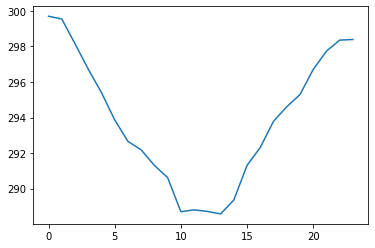

In [170]:
aa = var3.mean(['latitude','longitude'])
plt.plot(aa.t2m)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

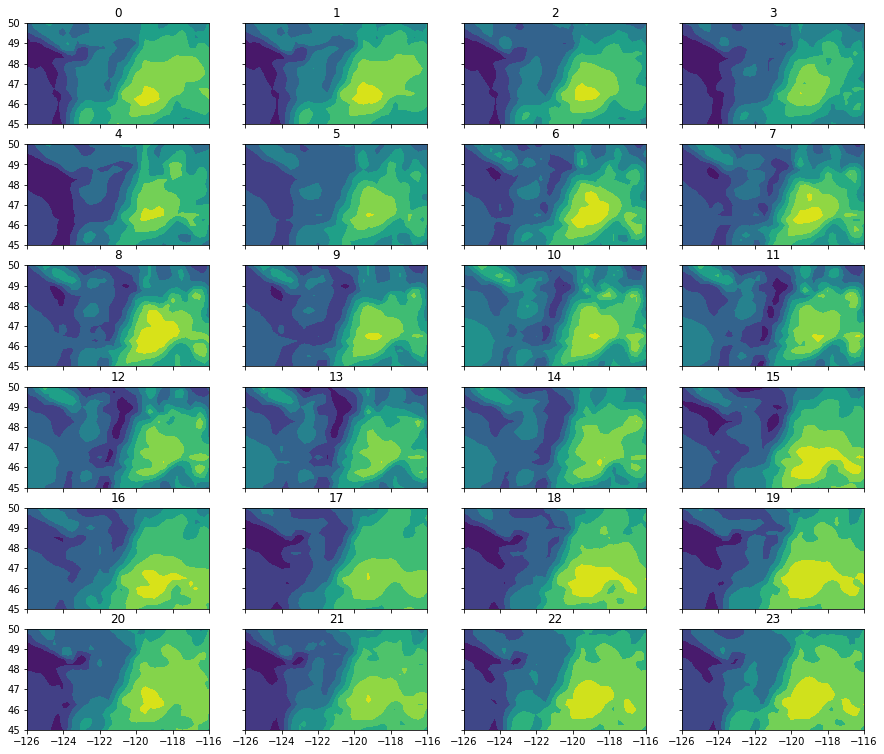

In [47]:
fig,ax = plt.subplots(6,4,figsize=(15,13),sharex=True,sharey=True)
for ii in range(6):
    for jj in range(4):
        ax[ii,jj].contourf(var2.longitude,var2.latitude,var3.t2m[ii*4+jj,:,:])
        ax[ii,jj].set_title(ii*4+jj)
plt.colorbar()

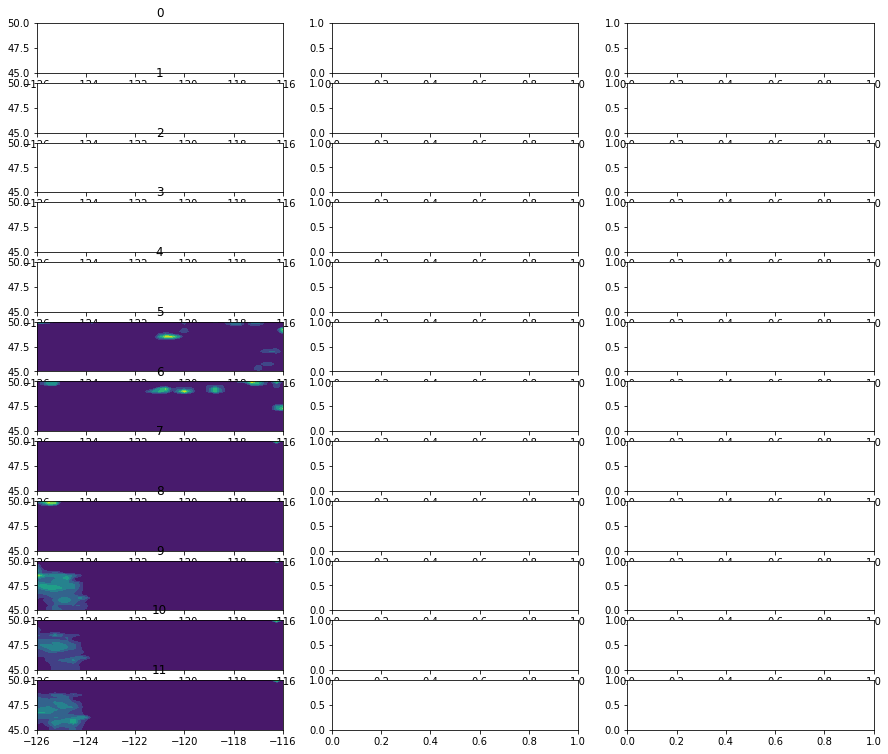

In [37]:
fig,ax = plt.subplots(4,3,figsize=(15,13))
for tt in range(5,6):
    for ii in range(12):
        ax[ii,tt-5].contourf(var2.longitude,var2.latitude,var2.tp[tt-5,ii,:,:])
        ax[ii,tt-5].set_title(ii)


In [15]:
var2.step/3600e9

<xarray.DataArray 'step' (step: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype='timedelta64[ns]')
Coordinates:
    number   int64 0
  * step     (step) timedelta64[ns] 01:00:00 02:00:00 ... 11:00:00 12:00:00
    surface  float64 0.0

In [7]:
var1

<xarray.Dataset>
Dimensions:     (time: 6, latitude: 21, longitude: 41)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-08-01T16:00:00 ... 2018-08-06T16:0...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 50.0 49.75 49.5 49.25 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 -126.0 -125.8 -125.5 ... -116.2 -116.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    u10         (time, latitude, longitude) float32 ...
    v10         (time, latitude, longitude) float32 ...
    t2m         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-04T12:47 GRIB to CDM+CF via cfgrib-0.9.1...

In [207]:
# Load the CSV file into a DataFrame
data = pd.read_csv('testBatch.csv') # data format: 1st line -- date format, latitude, ffmc, dmc, and dc values
                                    ## 2nd line --- temperature, relative humidity, wind speed, and rain

## initialize the relevant fire variables, i.e., ffmc, dmc, dc. 
## Calculation of ISI, BUI, FWI does not value of previous time step and therefore doesn't need to be initialized. 
N = data.shape[0]
ffmc = np.zeros(N+1)
dmc = np.zeros(N+1)
dc = np.zeros(N+1)
isi = np.zeros(N+1)
bui = np.zeros(N+1)
fwi = np.zeros(N+1)
    
ini_val = data.columns.tolist()
lat = float(ini_val[-4])
ffmc[0] = float(ini_val[-3]) # read in the initial value from the title of the data
dmc[0] = float(ini_val[-2])
dc[0] = float(ini_val[-1])

# Rename columns. Note that the initial value of ffmc, dmc, dc and fwi will now be replaced with 'ffmc','dmc','dc','fwi'
df = data.reset_index()
df.columns = ['Date', 'Temp', 'RH', 'Wind', 'Rain', 'Data','format','ffmc','dmc','dc','fwi']
df = df.drop(columns=['ffmc','dmc','dc','fwi'], axis=1)  ## to remove confusion, drop these columns. 


for ii in range(1,N+1):
    ffmc[ii] = FFMC(df['Temp'][ii-1],df['RH'][ii-1],df['Wind'][ii-1],df['Rain'][ii-1],ffmc[ii-1])#TEMP,RH,WIND,RAIN,FFMCPrev)
    dmc[ii] = DMC(df['Temp'][ii-1],df['RH'][ii-1],df['Rain'][ii-1],dmc[ii-1],lat,int(df.Date[ii-1][:2]))#TEMP,RH,RAIN,DMCPrev,LAT,MONTH)
    dc[ii] = DC(df['Temp'][ii-1],df['Rain'][ii-1],dc[ii-1],lat,int(df.Date[ii-1][:2]))#TEMP,RAIN,DCPrev,LAT,MONTH)
    isi[ii] = ISI(df['Wind'][ii-1],ffmc[ii])
    bui[ii] = BUI(dmc[ii],dc[ii])
    fwi[ii] = FWI(isi[ii],bui[ii])
    #print(ii,isi[ii],bui[ii],fwi[ii])